In [41]:
import numpy as np
import scipy.io.wavfile
import scipy.signal
from remi_module.remi_module_import import *
import matplotlib.pyplot as plt

time = 3
blank = 0
f1 = 440
f2 = 554.37
f3 = 659.26
f4 = 880
f5 = 523.25
fs = 44100

t = np.arange(0, fs * time)
s1 = np.sin(2 * np.pi * f1 * t/fs) * 5000
s_b = np.sin(2 * np.pi * blank * t/fs) * 5000
s2 = np.sin(2 * np.pi * f2 * t/fs) * 5000

In [42]:
RESULTS_PATH = "results/"

scipy.io.wavfile.write(RESULTS_PATH + "sin_1" + ".wav", fs, np.array(s1).astype(np.int16))
scipy.io.wavfile.write(RESULTS_PATH + "blank" + ".wav", fs, np.array(s_b).astype(np.int16))
scipy.io.wavfile.write(RESULTS_PATH + "sin_2" + ".wav", fs, np.array(s2).astype(np.int16))

In [43]:
from pydub import AudioSegment

sin1 = AudioSegment.from_wav("results/sin_1.wav")
blank = AudioSegment.from_wav("results/sin_2.wav")
sin2 = AudioSegment.from_wav("results/sin_2.wav")

y = sin1.overlay(sin2)
#y = y.overlay(sin3)
#y = y.overlay(sin4)
#y = y.overlay(sin5)

y.export("results/sin_mix.wav", format="wav")

<_io.BufferedRandom name='results/sin_mix.wav'>

1 466834.4004435442
2 -16278.816363607692
MIN AIC = -16278.816363607692 id : 1


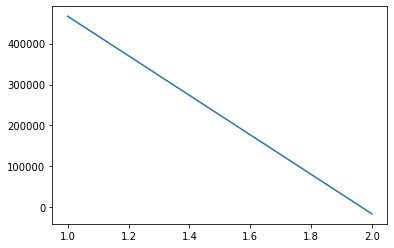

In [61]:
import sklearn.decomposition

# y = np.concatenate((s_b, s1, s_b, s2), axis=None)
# scipy.io.wavfile.write(RESULTS_PATH + "sin_mix" + ".wav", fs, np.array(y).astype(np.int16))

(_, signal_an) = scipy.io.wavfile.read("results/sin_mix.wav")
#(_, signal_n) = scipy.io.wavfile.read("results/sin_2.wav")


nperseg = 2048
_, _, Zxx_an = scipy.signal.stft(signal_an, fs, nperseg=nperseg)
#_, _, Zxx_n = scipy.signal.stft(signal_n, fs, nperseg=nperseg)

AICs = []
xs = np.arange(1, 3)

N = Zxx_an.shape[1] * Zxx_an.shape[0]

NMFs = []
NMFs_sum = []
for n_components in xs:
    #W, H = NMF(np.absolute(Zxx_an), n_components=n_components, max_iter=500, err=0.1)
    model_train = sklearn.decomposition.NMF(n_components=n_components, init='random', random_state=0, max_iter=100000)
    W = model_train.fit_transform(abs(Zxx_an))
    H = model_train.components_

    AICs.append(2 * n_components + N * np.log(pow(np.linalg.norm(np.absolute(Zxx_an) - W @ H), 2.0)  / N))

    print(str(n_components) + " " + str(AICs[-1]))
    NMFs_sum.append(np.sum(abs(Zxx_an) - W @ H))
    NMFs.append(np.linalg.norm(abs(Zxx_an) - W @ H))



print("MIN AIC = " + str(np.min(AICs)) + " id : " + str(np.argmin(AICs)))
plt.figure()
plt.plot(xs, AICs)
plt.show()

plt.figure()
plt.title("NMF over k")
plt.plot(xs, NMFs)
plt.show()

plt.figure()
plt.plot(xs, NMFs_sum)
plt.show()

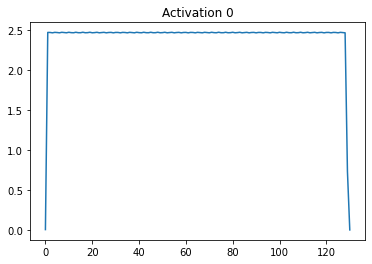

In [62]:


phase = np.angle(Zxx_an)
for j in range(n_components):

    s = np.outer(W[:,j],(H[j,:]))
    s = s * phase
    # print(len(scipy.signal.istft(s, fe_an)))
    Y = scipy.signal.istft(s, fs)[1]

    plt.figure()
    plt.title("Activation " + str(j))
    plt.plot(H[j,:])
    plt.show()

    scipy.io.wavfile.write(RESULTS_PATH + "res_0_" + str(j) + ".wav", fs, np.array(Y).astype(np.int16))